# **NMON ANALYSER WITH PYTHON**


## **This is script to parse the nmon file from Linux machine**

<Figure size 1500x800 with 0 Axes>

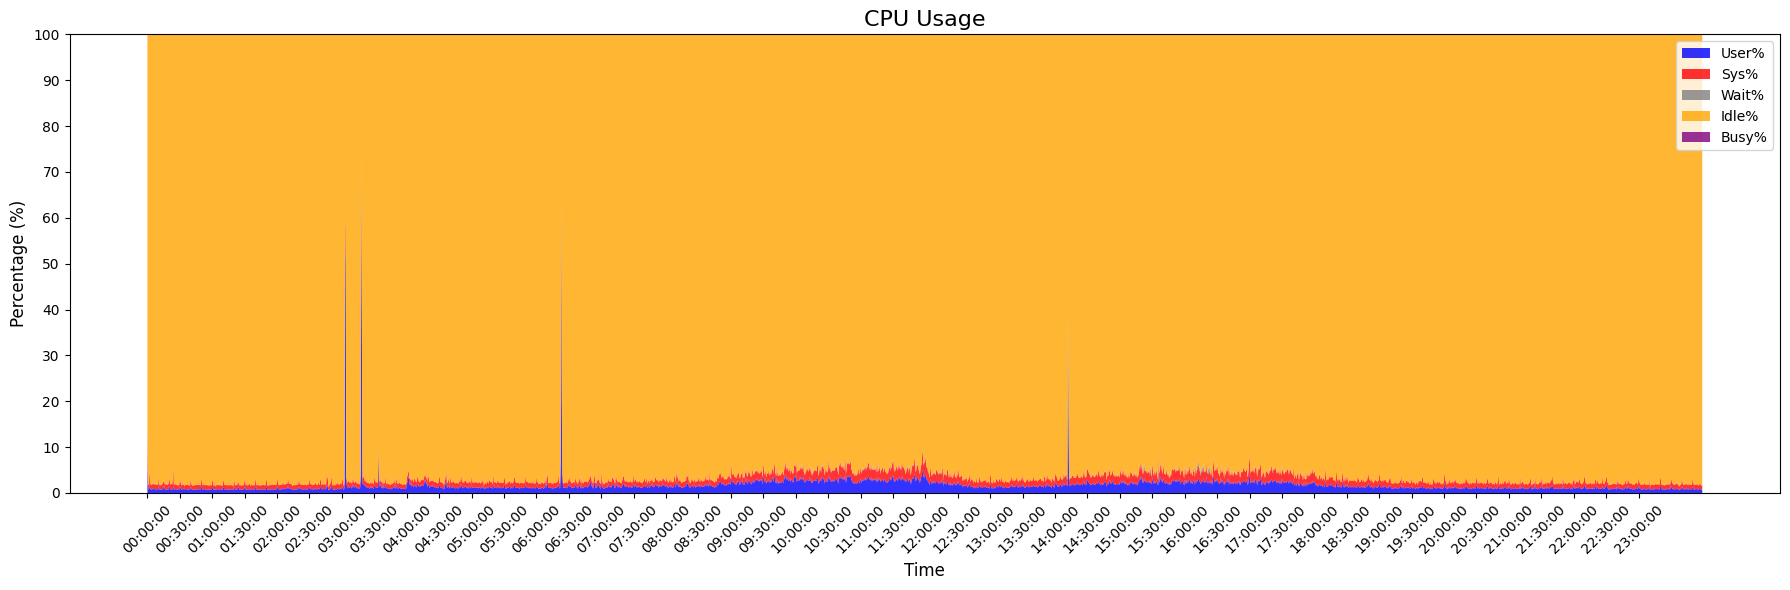

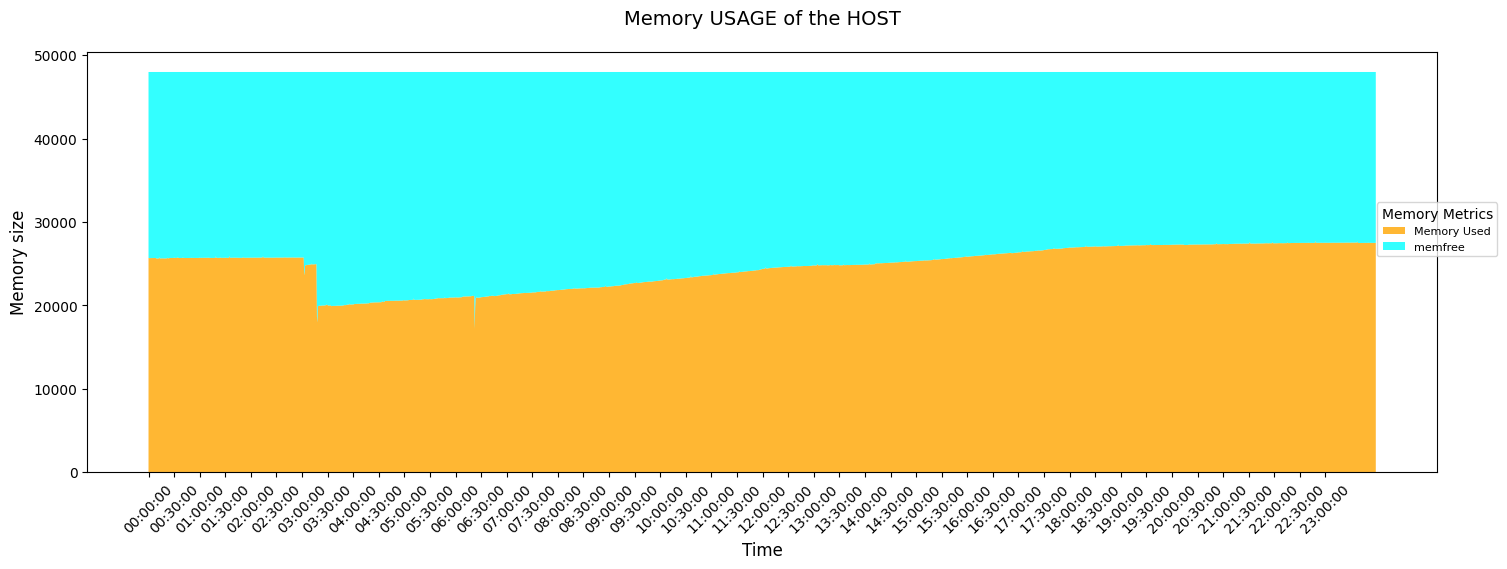

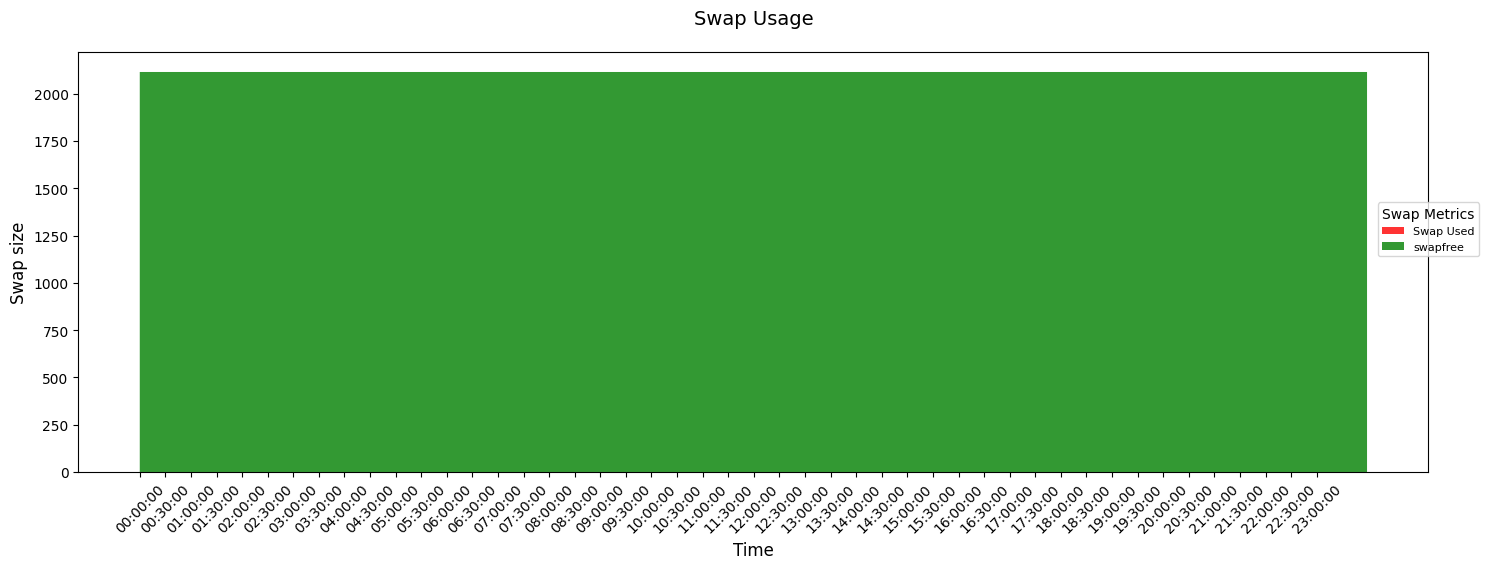

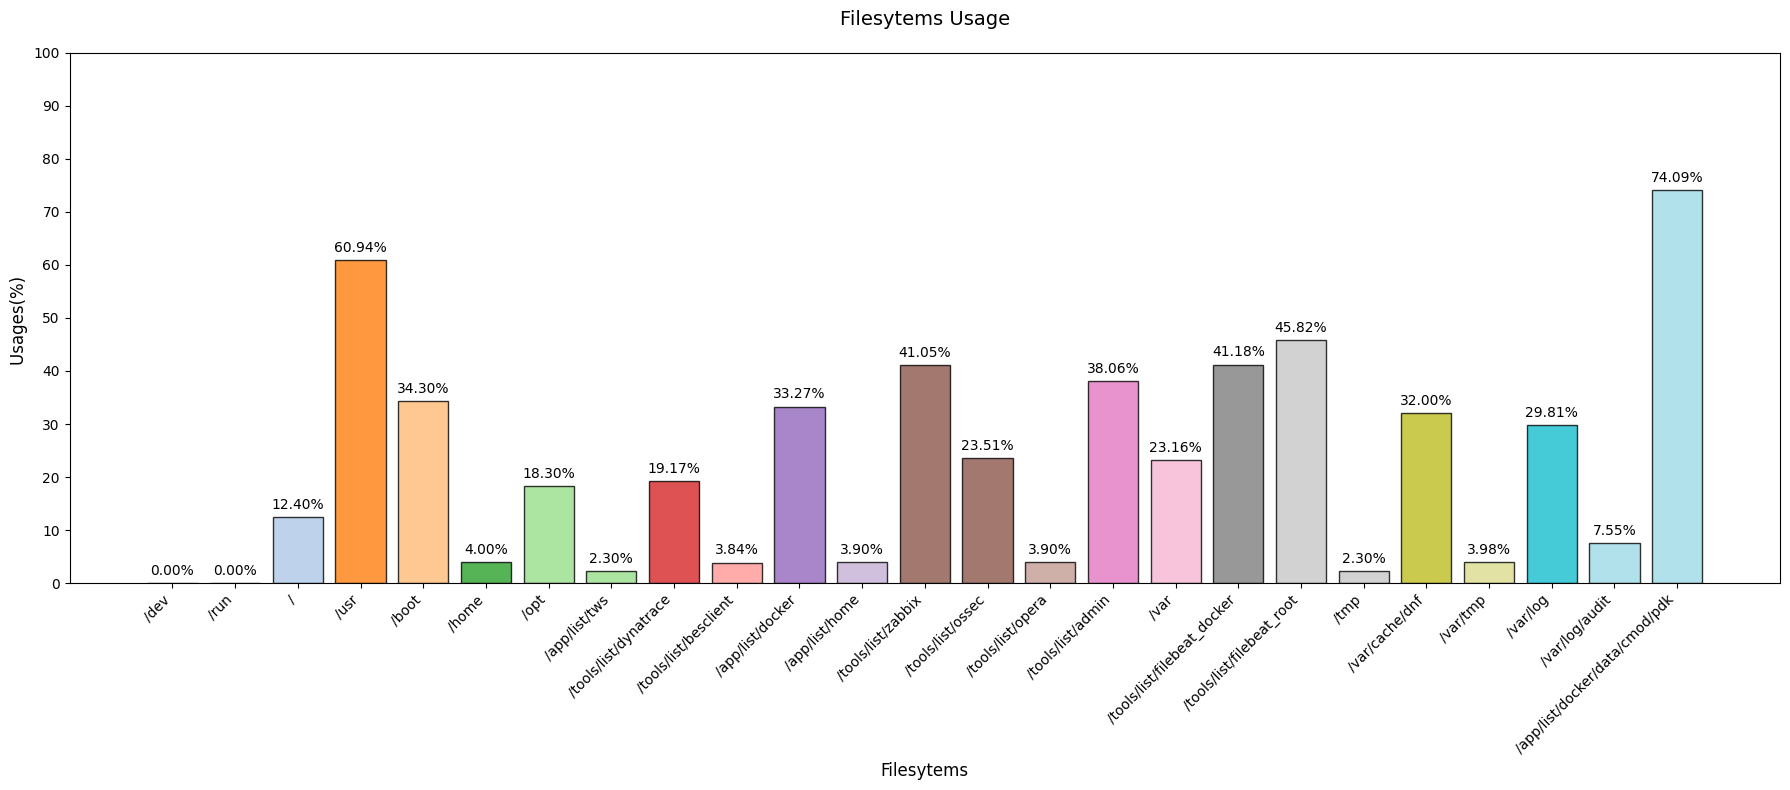

Original DataFrame shape: (5759, 6)
Cleaned NET DataFrame shape: (2879, 6)
Cleaned NETPACKET DataFrame shape: (2879, 6)


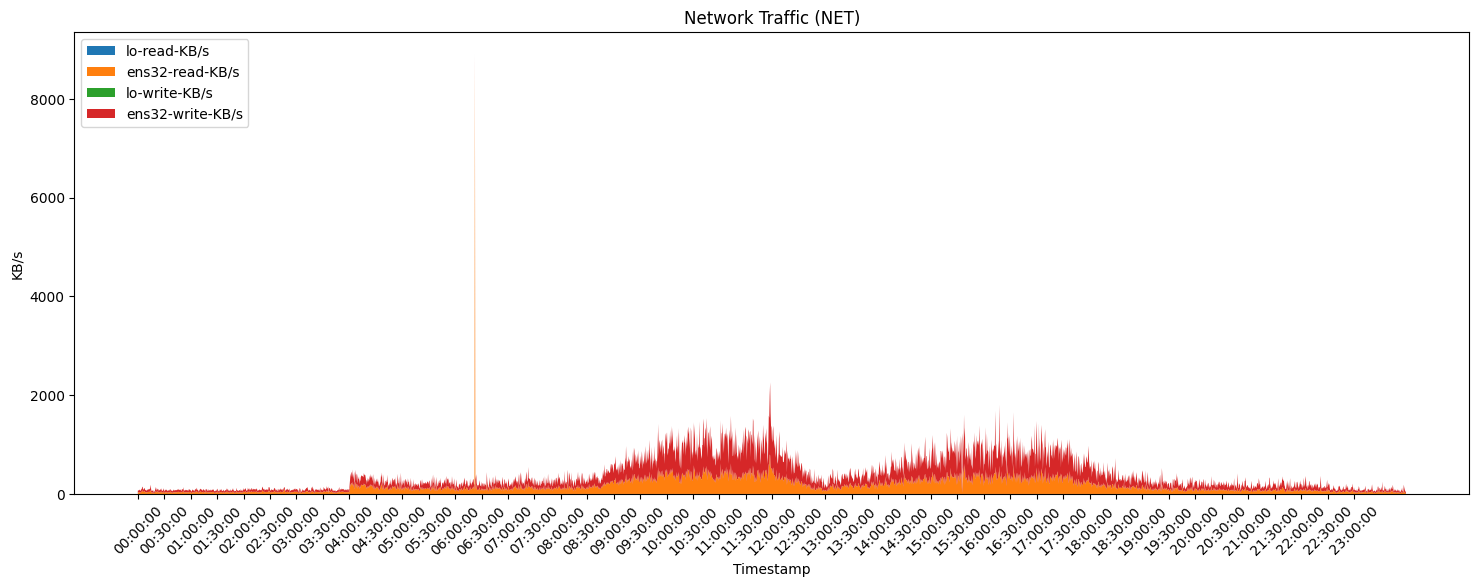

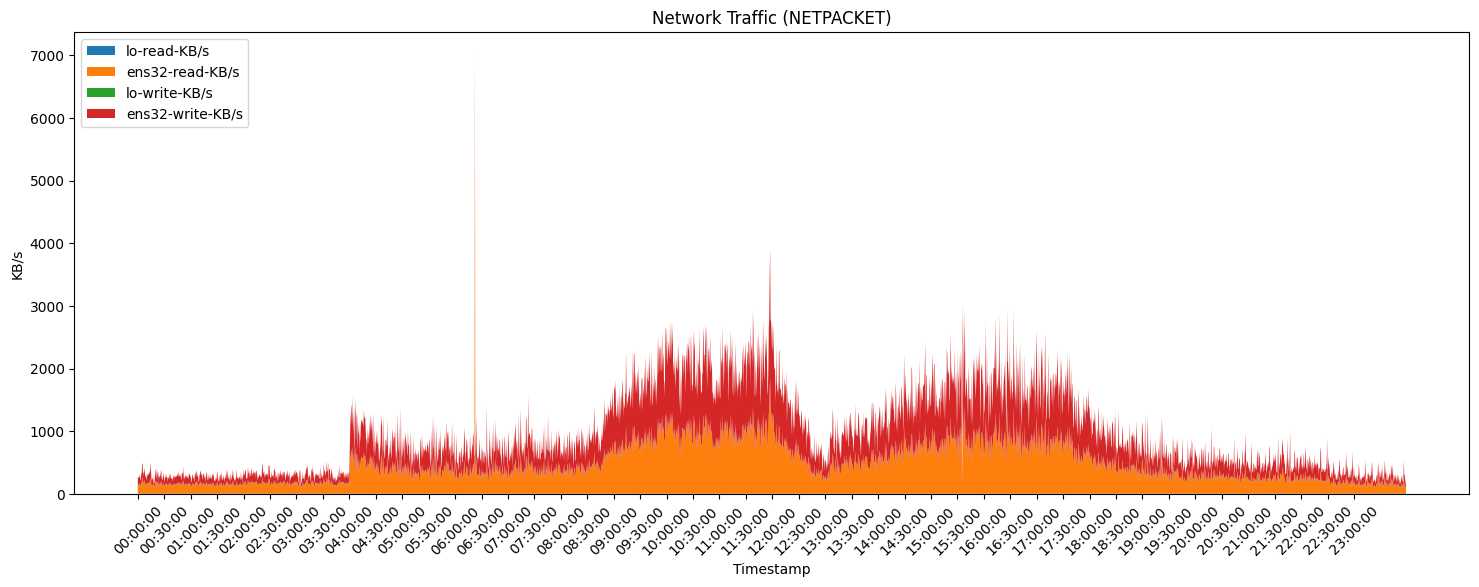

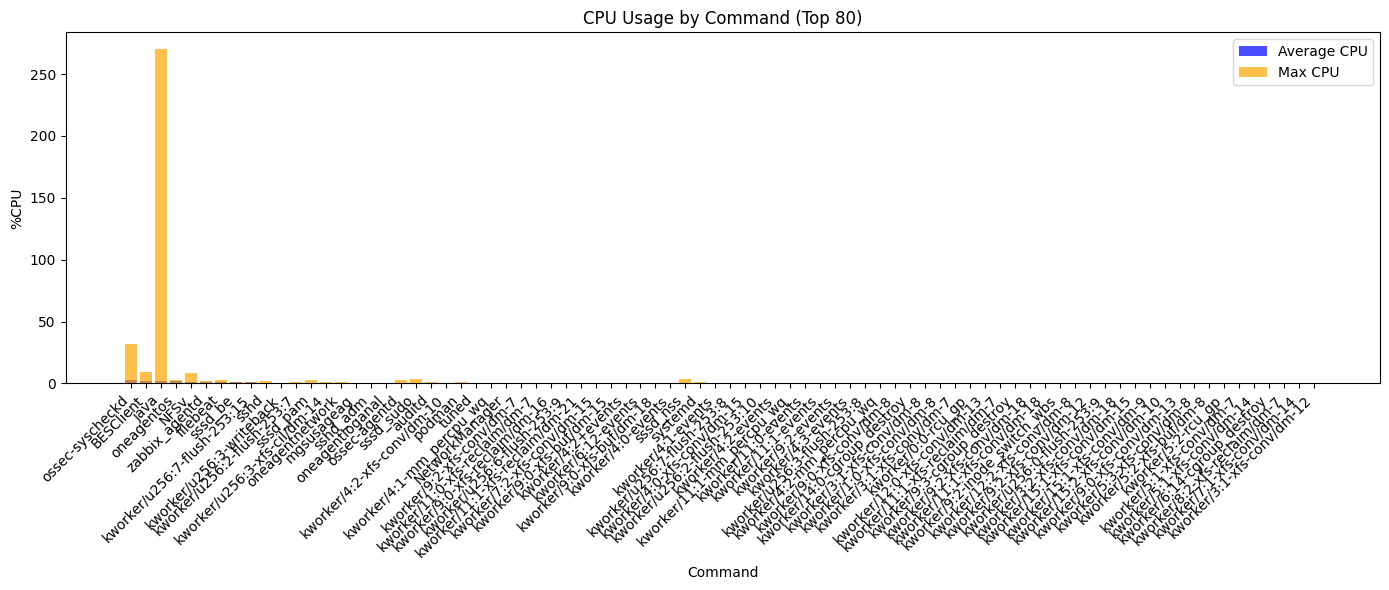

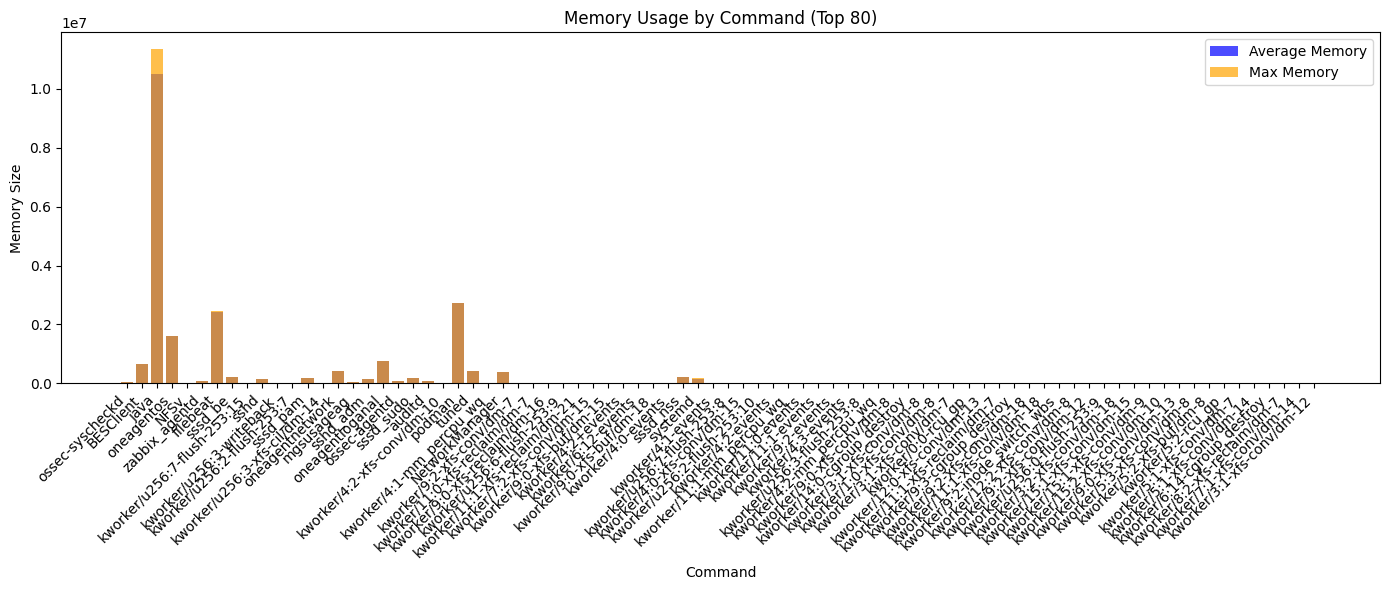

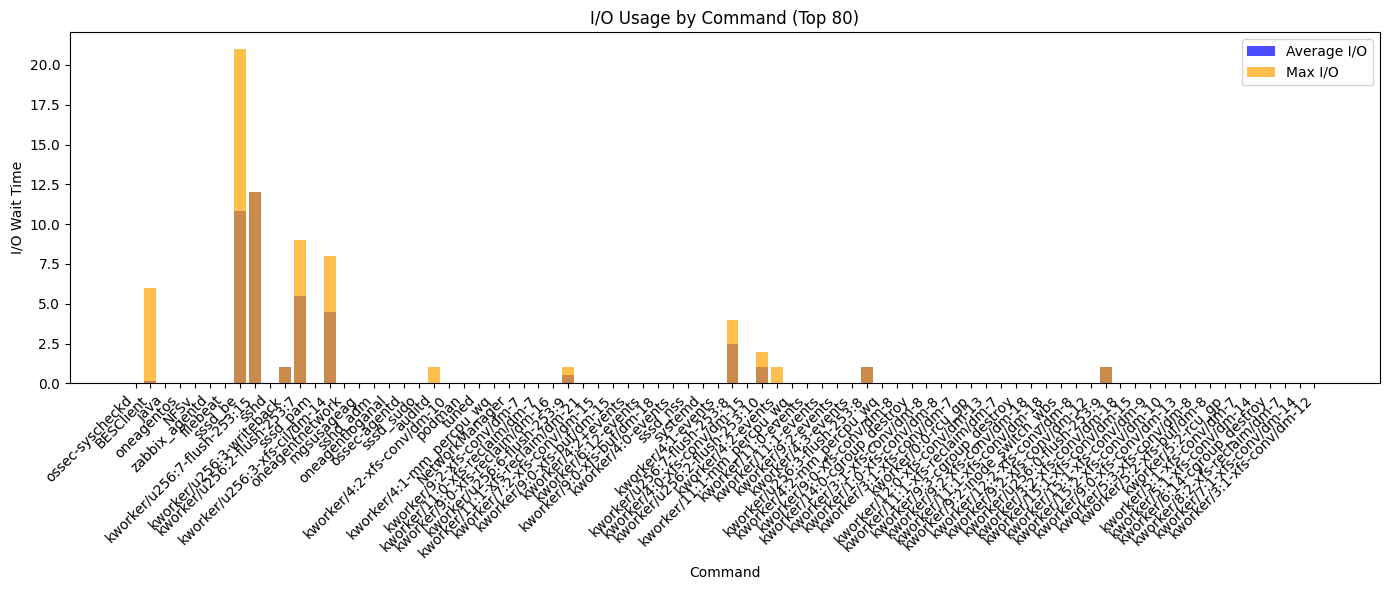

In [1]:
#This is script to parse the nmon file from Linux machine
####lstest one 
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def process_system_data(file_path, cpu_prefix="CPU", sections=None, timestamp_column="Timestamp"):
    """
    Processes system data from a file and organizes it into DataFrames for CPU and other sections.

    :param file_path: Path to the file containing system data.
    :param cpu_prefix: Prefix used for CPU data (e.g., "CPU").
    :param sections: List of section prefixes to process (e.g., ["MEM", "VM", "PROC"]).
    :param timestamp_column: The name for the timestamp column to include.
    :return: Dictionary of DataFrames keyed by section prefixes, including CPU data.
    """
    if sections is None:
        sections = ["CPU_ALL", "MEM", "VM", "PROC", "NET", "TOP", "NETPACKET", "JFSFILE",
                    "DISKBUSY", "DISKREAD", "DISKWRITE", "DISKXFER", "DISKBSIZE"]

    # Dictionaries to hold the data
    data_dict = {section: {"columns": [], "data": []} for section in [cpu_prefix] + sections}
    found_headers = set()

    with open(file_path, 'r') as file:
        top_section_found = False  # Flag to indicate when we encounter the top section
        for line in file:
            line = line.strip()

            # Skip empty lines or lines that don't start with a valid section
            if not line or not any(line.startswith(section) for section in [cpu_prefix] + sections):
                continue

            # Check for TOP section
            if line.startswith("TOP"):
                # Skip the first occurrence (header line with %CPU Utilisation)
                if not top_section_found:
                    top_section_found = True
                    continue  # Skip the first header line

                # The second line is the actual column header for TOP
                if "TOP" not in found_headers:
                    parts = re.split(r",\s*", line)
                    data_dict["TOP"]["columns"] = [timestamp_column] + parts[1:]  # Exclude 'TOP' as it's redundant
                    found_headers.add("TOP")
                else:
                    # Process data lines under TOP
                    parts = re.split(r",\s*", line)
                    if len(parts) == len(data_dict["TOP"]["columns"]):
                        data_dict["TOP"]["data"].append(parts)
                    continue

            # Check for CPU data
            if line.startswith(cpu_prefix):
                parts = re.split(r",\s*", line)

                cpu_id = parts[0]  # The first part (e.g., CPU001) is used as the key
                if cpu_id not in data_dict:
                    data_dict[cpu_id] = {"columns": [], "data": []}

                # If header not found for this CPU, extract headers
                if cpu_id not in found_headers:
                    data_dict[cpu_id]["columns"] = [cpu_prefix, timestamp_column] + parts[2:]
                    found_headers.add(cpu_id)
                else:
                    # Add data line, ensure it matches the header length
                    if len(parts) == len(data_dict[cpu_id]["columns"]):
                        data_dict[cpu_id]["data"].append(parts)
                continue

            # Check for other sections
            for section in sections:
                if line.startswith(section):
                    parts = re.split(r",\s*", line)

                    # If header not found for this section, extract headers
                    if section not in found_headers:
                        # Use the current line as the header for this section
                        data_dict[section]["columns"] = [section, timestamp_column] + parts[2:]
                        found_headers.add(section)
                    else:
                        # Add data line, ensure it matches the header length
                        if len(parts) == len(data_dict[section]["columns"]):
                            data_dict[section]["data"].append(parts)
                    break

    # Convert each section's data into a DataFrame
    dataframes = {}
    for section, data in data_dict.items():
        if data["data"]:  # Only create DataFrame if there is data
            # Ensure no mismatch in number of columns before creating DataFrame
            max_columns = len(data["columns"])
            valid_data = [row for row in data["data"] if len(row) == max_columns]
            
            # If there is valid data, create DataFrame
            if valid_data:
                df = pd.DataFrame(valid_data, columns=data["columns"])
                dataframes[section] = df

    return dataframes


def plot_cpu(cpu_all_df, start_time="00:00:00", interval_seconds=30, num_records=2879):
    """
    Plots Idle% and Busy% against timestamps for the CPU_ALL DataFrame.

    :param cpu_all_df: DataFrame containing the aggregated CPU_ALL data.
    :param start_time: Start time of the data collection (HH:MM:SS format).
    :param interval_seconds: Interval in seconds between data points (30 seconds for nmon).
    :param num_records: Total number of records in the dataset.
    """
    # Convert the relevant columns to numeric, forcing errors to NaN (in case of any non-numeric values)
    cpu_all_df['User%'] = pd.to_numeric(cpu_all_df['User%'], errors='coerce')
    cpu_all_df['Sys%'] = pd.to_numeric(cpu_all_df['Sys%'], errors='coerce')
    cpu_all_df['Wait%'] = pd.to_numeric(cpu_all_df['Wait%'], errors='coerce')
    cpu_all_df['Idle%'] = pd.to_numeric(cpu_all_df['Idle%'], errors='coerce')
    cpu_all_df['Steal%'] = pd.to_numeric(cpu_all_df['Steal%'], errors='coerce')

    # Generate a datetime range based on the number of records and interval
    start_datetime = datetime.strptime(start_time, "%H:%M:%S")
    cpu_all_df['Timestamp'] = [
        start_datetime + timedelta(seconds=i * interval_seconds) for i in range(num_records)
    ]

    # Calculate Busy% as the sum of User%, Sys%, and Wait% (but make sure it's <= 100%)
    cpu_all_df['Busy%'] = cpu_all_df['User%'] + cpu_all_df['Sys%']
    cpu_all_df['Busy%'] = cpu_all_df['Busy%'].clip(upper=100)  # Ensure it doesn't go over 100%

    # Ensure Idle% is present in the DataFrame
    if 'Idle%' not in cpu_all_df.columns:
        print("Idle% column not found in the DataFrame.")
        return

    # Set up the plot
    plt.figure(figsize=(15, 8))



    timestamp_col = "Timestamp"  # Replace with your timestamp column name
    columns_to_plot = ['User%', 'Sys%', 'Wait%', 'Idle%', 'Busy%']  # Replace with your column names



    # Colors for the stacked areas
    area_colors = ['blue', 'red', 'gray', 'orange', 'purple']

    # Plotting
    plt.figure(figsize=(18, 6))  # Set the figure size
    plt.stackplot(cpu_all_df[timestamp_col],
              [cpu_all_df[col] for col in columns_to_plot],
              labels=columns_to_plot,
              colors=area_colors,
              alpha=0.8)  # Adjust transparency for better visual clarity


    # Set x-axis ticks to 30-minute intervals
    x_ticks = pd.date_range(start=start_datetime, periods=num_records // 60, freq="30min")
    plt.xticks(x_ticks, [t.strftime("%H:%M:%S") for t in x_ticks], rotation=45)

    # Add labels, title, legend, and grid
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.title('CPU Usage', fontsize=16)
    plt.legend(loc='upper right')
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Limit y-axis to 0-100% and set ticks at intervals of 20
    plt.ylim(0, 100)
    plt.yticks(range(0, 101, 10))  # Set y-axis ticks at 0, 20, 40, ..., 100%

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


#grpah for memory

def plot_memory(mem_dfs, start_time="00:00:00", interval_seconds=30, num_records=2879):
    """
    Plot a stacked area chart from a DataFrame.
    
    Parameters:
    - df (DataFrame): Input DataFrame containing the data.
    - timestamp_col (str): Column name for the x-axis (timestamps).
    - metrics (list): List of column names to plot as stacked areas.
    - colors (list): List of colors for each metric.
    - title (str): Title of the chart.
    - y_label (str): Label for the y-axis.
    """

    mem_dfs['memtotal'] = pd.to_numeric(mem_dfs['memtotal'], errors='coerce')
    mem_dfs['memfree'] = pd.to_numeric(mem_dfs['memfree'], errors='coerce')
    
    
    start_datetime = datetime.strptime(start_time, "%H:%M:%S")
    mem_dfs['Timestamp'] = [
        start_datetime + timedelta(seconds=i * interval_seconds) for i in range(num_records)
    ]

    mem_dfs['Memory Used'] = mem_dfs['memtotal'] - mem_dfs['memfree']
    
    timestamp_col = "Timestamp"  # Replace with your timestamp column name
    columns_to_plot = ['Memory Used', 'memfree']  # Replace with your column names
    
    area_colors = ['orange', 'cyan'] 
    
    # Ensure the timestamp column and metric columns exist in the DataFrame
    if timestamp_col not in mem_dfs.columns or not all(col in mem_dfs.columns for col in columns_to_plot):
        raise ValueError("Invalid column names provided for plotting.")

    # Plot the stacked area chart
    fig, ax = plt.subplots(figsize=(18, 6))
    plt.stackplot(mem_dfs[timestamp_col], 
                  [mem_dfs[col] for col in columns_to_plot], 
                  labels=columns_to_plot, 
                  colors=area_colors, 
                  alpha=0.8)

    # Set x-axis ticks to 30-minute intervals
    x_ticks = pd.date_range(start=start_datetime, periods=num_records // 60, freq="30min")
    plt.xticks(x_ticks, [t.strftime("%H:%M:%S") for t in x_ticks], rotation=45)
    
    # Add labels and title
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Memory size', fontsize=12)
    ax.set_title("Memory USAGE of the HOST", fontsize=14, pad=20)
    ax.tick_params(axis='x', rotation=45)

    # Adjust the layout and add padding
    plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.2)  # Adjust plot padding

    # Position the legend outside the plot
    ax.legend(
        loc='lower center',
        bbox_to_anchor=(1, 0.5),  # Place legend outside on the right margin
        title='Memory Metrics',
        fontsize=8,
        title_fontsize=10,
    )
    
    # Display the plot
    plt.show()


def plot_swap(mem_dfs, start_time="00:00:00", interval_seconds=30, num_records=2879):
    """
    Plot a stacked area chart from a DataFrame.
    
    Parameters:
    - df (DataFrame): Input DataFrame containing the data.
    - timestamp_col (str): Column name for the x-axis (timestamps).
    - metrics (list): List of column names to plot as stacked areas.
    - colors (list): List of colors for each metric.
    - title (str): Title of the chart.
    - y_label (str): Label for the y-axis.
    """

    mem_dfs['swaptotal'] = pd.to_numeric(mem_dfs['swaptotal'], errors='coerce')
    mem_dfs['swapfree'] = pd.to_numeric(mem_dfs['swapfree'], errors='coerce')
    
    
    start_datetime = datetime.strptime(start_time, "%H:%M:%S")
    mem_dfs['Timestamp'] = [
        start_datetime + timedelta(seconds=i * interval_seconds) for i in range(num_records)
    ]

    mem_dfs['Swap Used'] = mem_dfs['swaptotal'] - mem_dfs['swapfree']
    
    timestamp_col = "Timestamp"  # Replace with your timestamp column name
    columns_to_plot = ['Swap Used', 'swapfree']  # Replace with your column names
    
    area_colors = ['red', 'green'] 
    
    # Ensure the timestamp column and metric columns exist in the DataFrame
    if timestamp_col not in mem_dfs.columns or not all(col in mem_dfs.columns for col in columns_to_plot):
        raise ValueError("Invalid column names provided for plotting.")

    # Plot the stacked area chart
    fig, ax = plt.subplots(figsize=(18, 6))
    plt.stackplot(mem_dfs[timestamp_col], 
                  [mem_dfs[col] for col in columns_to_plot], 
                  labels=columns_to_plot, 
                  colors=area_colors, 
                  alpha=0.8)

    # Set x-axis ticks to 30-minute intervals
    x_ticks = pd.date_range(start=start_datetime, periods=num_records // 60, freq="30min")
    plt.xticks(x_ticks, [t.strftime("%H:%M:%S") for t in x_ticks], rotation=45)
    
    # Add labels and title
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Swap size', fontsize=12)
    ax.set_title("Swap Usage", fontsize=14, pad=20)
    ax.tick_params(axis='x', rotation=45)

    # Adjust the layout and add padding
    plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.2)  # Adjust plot padding

    # Position the legend outside the plot
    ax.legend(
        loc='lower center',
        bbox_to_anchor=(1, 0.5),  # Place legend outside on the right margin
        title='Swap Metrics',
        fontsize=8,
        title_fontsize=10,
    )
    
    # Display the plot
    plt.show()


def plot_filesystem(fs_df):
    """
    Plot the average values of JSPFILE data columns (excluding timestamp) 
    as percentages with X-axis as column headers and Y-axis from 0 to 100%.
    
    Parameters:
    - df (DataFrame): Input DataFrame containing the data.
    - timestamp_col (str): Column name for the timestamp to exclude.
    - title (str): Title of the chart.
    - y_label (str): Label for the y-axis.
    """
    timestamp_col = ["Timestamp","JFSFILE"]
    for col in fs_df.columns:
        if col != timestamp_col:
            fs_df[col] = pd.to_numeric(fs_df[col], errors='coerce')

    
    
    columns_to_plot = [
    col for col in fs_df.columns if col != timestamp_col and pd.api.types.is_numeric_dtype(fs_df[col])
    ]

    if not columns_to_plot:
        raise ValueError("No numeric columns found to plot!")

    averages = fs_df[columns_to_plot].mean().dropna()

    colors = plt.cm.tab20(np.linspace(0, 1, len(averages)))
    # Exclude the timestamp column and calculate averages for other columns

    # Create the plot
    fig, ax = plt.subplots(figsize=(18, 8))
    bars = ax.bar(
        averages.index,
        averages.values,
        color=colors,
        edgecolor='black',
        alpha=0.8,
    )

    # Annotate each bar with its value
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 1,
            f"{height:.2f}%",
            ha='center',
            va='bottom',
            fontsize=10,
        )

    # Add labels, title, and ticks
    ax.set_xlabel('Filesytems', fontsize=12)
    ax.set_ylabel('Usages(%) ', fontsize=12)
    ax.set_title('Filesytems Usage', fontsize=14, pad=20)
    ax.set_ylim(0, 100)  # Set Y-axis from 0 to 100%
    ax.set_yticks(range(0, 101, 10))  # Tick every 10%
    ax.tick_params(axis='x', rotation=45)  # Rotate X-axis labels for readability

    ax.set_xticks(range(len(averages.index)))
    ax.set_xticklabels(averages.index, rotation=45, ha='right', fontsize=10)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


def plot_network_usage(net_df,  start_time="00:00:00", interval_seconds=30, num_records=2879):
    """
    Cleans the input DataFrame, separates NET and NETPACKET data, 
    and creates stack plots for network usage data.
    
    Parameters:
    - net_df (DataFrame): Input DataFrame containing network and NETPACKET data.
    """
    # Debug: Print original shape
    print("Original DataFrame shape:", net_df.shape)

    # Remove the header row for NETPACKET
    net_df = net_df[net_df["Timestamp"] != "Network Packets my_linux_host001"]
    
    # Split into NET and NETPACKET
    net_data = net_df[net_df["NET"] == "NET"].copy()
    netpacket_data = net_df[net_df["NET"] == "NETPACKET"].copy()

    start_datetime = datetime.strptime(start_time, "%H:%M:%S")
    net_data['Timestamp'] = [
        start_datetime + timedelta(seconds=i * interval_seconds) for i in range(num_records)
    ]

    start_datetime = datetime.strptime(start_time, "%H:%M:%S")
    netpacket_data['Timestamp'] = [
        start_datetime + timedelta(seconds=i * interval_seconds) for i in range(num_records)
    ]

    # Convert numeric columns to float
    columns_to_convert = ["lo-read-KB/s", "ens32-read-KB/s", "lo-write-KB/s", "ens32-write-KB/s"]
    for col in columns_to_convert:
        net_data[col] = pd.to_numeric(net_data[col], errors="coerce")
        netpacket_data[col] = pd.to_numeric(netpacket_data[col], errors="coerce")

    # Debug: Print cleaned shapes
    print("Cleaned NET DataFrame shape:", net_data.shape)
    print("Cleaned NETPACKET DataFrame shape:", netpacket_data.shape)

    # Plot NET data
    plt.figure(figsize=(18, 6))
    plt.stackplot(
        net_data["Timestamp"], 
        net_data["lo-read-KB/s"], 
        net_data["ens32-read-KB/s"], 
        net_data["lo-write-KB/s"], 
        net_data["ens32-write-KB/s"], 
        labels=["lo-read-KB/s", "ens32-read-KB/s", "lo-write-KB/s", "ens32-write-KB/s"]
    )
    plt.title("Network Traffic (NET)")
    plt.xlabel("Timestamp")
    plt.ylabel("KB/s")
    plt.legend(loc="upper left")
    
    # Set x-axis ticks to 30-minute intervals
    x_ticks = pd.date_range(start=start_datetime, periods=num_records // 60, freq="30min")
    plt.xticks(x_ticks, [t.strftime("%H:%M:%S") for t in x_ticks], rotation=45)
    plt.show()

    # Plot NETPACKET data
    plt.figure(figsize=(18, 6))
    plt.stackplot(
        netpacket_data["Timestamp"], 
        netpacket_data["lo-read-KB/s"], 
        netpacket_data["ens32-read-KB/s"], 
        netpacket_data["lo-write-KB/s"], 
        netpacket_data["ens32-write-KB/s"], 
        labels=["lo-read-KB/s", "ens32-read-KB/s", "lo-write-KB/s", "ens32-write-KB/s"]
    )
    plt.title("Network Traffic (NETPACKET)")
    plt.xlabel("Timestamp")
    plt.ylabel("KB/s")
    plt.legend(loc="upper left")
        # Set x-axis ticks to 30-minute intervals
    x_ticks = pd.date_range(start=start_datetime, periods=num_records // 60, freq="30min")
    plt.xticks(x_ticks, [t.strftime("%H:%M:%S") for t in x_ticks], rotation=45)
    plt.show()


def process_and_plot_top_data(top_df, top_n=80):
    """
    Processes the TOP data, calculates resource usage for each command, and plots the results
    for the top N commands with dynamic x-axis management.

    Parameters:
    - top_df (DataFrame): The input TOP DataFrame.
    - top_n (int): The number of top commands to display based on average CPU usage.
    """
    # Ensure numeric columns are converted properly
    numeric_cols = ["%CPU", "%Usr", "%Sys", "Size", "ResSet", "IOwaitTime"]
    for col in numeric_cols:
        top_df[col] = pd.to_numeric(top_df[col], errors="coerce")
    
    # Drop rows with missing or invalid values in critical columns
    top_df.dropna(subset=["%CPU", "Size", "IOwaitTime"], inplace=True)
    
    # Group by Command and calculate statistics
    grouped = top_df.groupby("Command").agg(
        Avg_CPU=("%CPU", "mean"),
        Max_CPU=("%CPU", "max"),
        Min_Memory=("Size", "min"),
        Avg_Memory=("Size", "mean"),
        Max_Memory=("Size", "max"),
        Avg_IO=("IOwaitTime", "mean"),
        Max_IO=("IOwaitTime", "max"),
    ).reset_index()

    # Sort by Average CPU and limit to top N commands
    grouped = grouped.sort_values(by="Avg_CPU", ascending=False).head(top_n)

    # Generate x-axis indices
    x_ticks = grouped["Command"]
    x_indices = np.arange(len(x_ticks))  # Indexes for the x-axis

    # Plot CPU usage
    plt.figure(figsize=(14, 6))
    plt.bar(x_indices, grouped["Avg_CPU"], label="Average CPU", color="blue", alpha=0.7)
    plt.bar(x_indices, grouped["Max_CPU"], label="Max CPU", color="orange", alpha=0.7)
    plt.title(f"CPU Usage by Command (Top {top_n})")
    plt.xlabel("Command")
    plt.ylabel("%CPU")
    plt.xticks(x_indices, x_ticks, rotation=45, ha="right")  # Dynamically set ticks
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot Memory usage
    plt.figure(figsize=(14, 6))
    plt.bar(x_indices, grouped["Avg_Memory"], label="Average Memory", color="blue", alpha=0.7)
    plt.bar(x_indices, grouped["Max_Memory"], label="Max Memory", color="orange", alpha=0.7)
    plt.title(f"Memory Usage by Command (Top {top_n})")
    plt.xlabel("Command")
    plt.ylabel("Memory Size")
    plt.xticks(x_indices, x_ticks, rotation=45, ha="right")  # Dynamically set ticks
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot I/O usage
    plt.figure(figsize=(14, 6))
    plt.bar(x_indices, grouped["Avg_IO"], label="Average I/O", color="blue", alpha=0.7)
    plt.bar(x_indices, grouped["Max_IO"], label="Max I/O", color="orange", alpha=0.7)
    plt.title(f"I/O Usage by Command (Top {top_n})")
    plt.xlabel("Command")
    plt.ylabel("I/O Wait Time")
    plt.xticks(x_indices, x_ticks, rotation=45, ha="right")  # Dynamically set ticks
    plt.legend()
    plt.tight_layout()
    plt.show()



# Example usage
# Assuming `net_df` is your DataFrame
# plot_network_usage(net_df)


# Example Usage
# Assuming `cpu_all_df` is the DataFrame for CPU_ALL data

# Example usage
file_path = "my_nmon.csv"  # Replace with the path to your file

dataframes = process_system_data(file_path)

# `dataframes` now contains a DataFrame for each CPU and each section
# Example: Accessing the TOP DataFrame
top_df = dataframes.get("TOP")
cpu_df = dataframes.get("CPU_ALL")
mem_df =  dataframes.get("MEM")
vm_df =  dataframes.get("VM")
net_df =  dataframes.get("NET")
fs_df =  dataframes.get("JFSFILE")
diskb_df =  dataframes.get("DISKBUSY")


# Print the DataFrame 
#dataframes

plot_cpu(cpu_df)
plot_memory(mem_df)
plot_swap(mem_df)
plot_filesystem(fs_df)
plot_network_usage(net_df)
process_and_plot_top_data(top_df)
#print(net_df)

